In [1]:
import numpy as np
import matplotlib.pyplot as plt
import png
import os
import random

In [2]:
# Take sliding window sub set of whole dataset
# normalise values between 0 & sliding window size 
# (except alpha values need to be normailsed between 0 and 255)
# Tranform into new image RGB(a) array where:
#   Open=Orange (255,165,0), High=Green (0,128,0), Close=Blue (0,0,128), Low=Red (128,0,0) and 
#   co-ord in image relates to index in original window and new normalised value
def CreateImageFromSlidingWindow(sourceArray, windowSize, initialIndex, channels=3):
 if channels == 3:
    openColour = [255,165,0] 
    highColour = [0,128,0]
    lowColour = [128,0,0]
    closeColour =[0,0,255]
    imgDims = (windowSize, windowSize, channels)
 elif channels == 1:
    openColour = 64 
    highColour = 128
    lowColour = 128
    closeColour =255
    imgDims = (windowSize, windowSize, 1)
 
 imageData = sourceArray[initialIndex:initialIndex + windowSize - 1]
 #print imageData
 #normalise values to the image size -TODO: Make it sort out values where min - max = close to 0...   
 min = imageData.min()
 max = imageData.max()
 X = abs((windowSize-1) - ((windowSize-1)*(imageData-min)/(max - min)))
 X = X.round().astype(int)
 #print X
    
 # createImageArray
 image = np.zeros(imgDims, dtype=np.bool) #dtype=np.uint8)
 # for each row in the imageData Array 
 #  The row index corresponds to a column in the ImageArray and the values corresponds to the y index to set)   

 for i in range(0,windowSize-1):
    #set Open
    #image[X[i,0],i] = openColour
    #set High
    #image[X[i,1],i] = highColour
    #set Low
    #image[X[i,2],i] = lowColour
    #set Close
    image[X[i,3],i] = closeColour
 
 scaled = image.astype(np.float32)
 scaled = (scaled - (255 / 2.0)) / 255
 
    #print np.shape(image)        
 return scaled 

def generateImagesArray(sourceData, windowSize, dataBasePath, channels):
    if not os.path.exists(dataBasePath):
        os.makedirs(dataBasePath)
        
    imageCount = len(sourceData)-windowSize
    print('Processing imageCount:',  str(imageCount))
    
    imgDims = (imageCount, windowSize, windowSize, channels)
        
    imagesArray = np.empty(imgDims, dtype=np.float32)
    
    for i in range(0, imageCount):
     if i % 10000 == 0:
      print ('Processing pass: ' + str(i) + ', index: ' + str(i))
     image = CreateImageFromSlidingWindow(sourceData,windowSize,i,channels)
     imagesArray[i] = image
    np.save(dataBasePath + 'raw.npy', imagesArray)
    std = np.std(imagesArray, dtype=np.float64)
    mean = np.mean(imagesArray, dtype=np.float64)
    print ('ImagesArray: Std=' + str(std), 'Mean=' + str(mean))
    
def generateImages(sourceData, windowSize, dataBasePath, channels):
    if not os.path.exists(dataBasePath):
        os.makedirs(dataBasePath)
    imageCount = len(sourceData)-windowSize
    print ('Processing imageCount:' + str(imageCount))
    for i in range(0, imageCount):
     if i % 10000 == 0:
      print ('Processing pass: ' + str(i) + ', index: ' + str(i))
     image = CreateImageFromSlidingWindow(sourceData,windowSize,i,channels)
     imageFileName = dataBasePath + str(i) + '-' + str(i+windowSize-1) + '.png'
     saveImage(image, windowSize, windowSize, channels, imageFileName, '1')
    
# def saveImageOld(immageArr, width, height, planes, imageFilename):
#     reshapedImage = np.reshape(immageArr, ( -1, width*planes,))
#     f = open(imageFilename, 'wb')      # binary mode is important
#     pngWriter = png.Writer(width, height, bitdepth=8)
#     pngWriter.write(f, reshapedImage)
#     f.close()

from PIL import Image
def saveImage(immageArr, width, height, planes, imageFilename, mode='L'):
    image = Image.fromarray(immageArr, mode)
    image.save(imageFilename)

# def loadImageOld(imagePath):
#     return plt.imread(imagePath)

def loadImage(imagePath):
    return np.asarray(Image.open(imagePath))
        
def shift(data, amount):
    data = data[:-amount]
    pad = (amount, 0)
    return np.pad(data, pad, mode='constant', constant_values=(np.nan,))

def generateAlignedLabels(sourceArray, windowSize):
    allLabels = generateLabels(sourceArray)
    #fucking important - subset from sliding window indices!!!
    return allLabels[slidingWindow:]

def generateLabels(sourceArray):
    O, H, L, C = sourceArray.T
    C1 = shift(C, 1)
    # 3 categories:  
    # Where C[0]=C[-1] Class = 0
    # Where C[0]>C[-1] Class = 1
    # Where C[0]<C[-1] Class = 2
    #labels = np.where(C>C1, 1, np.where(C<C1,2, 0))
    
    # 2 categories:
    # Where C[0]>C[-1] Class = 1
    # Where C[0]<=C[-1] Class = 0
    labels = np.where(C>C1, 1,  0)
    return labels

def generateLabelFile(labelData, windowSize, dataBasePath):
    # Now produce some labels in a format that TFLearn can use...
    # /path/to/img1 class_id
    # /path/to/img2 class_id
    # /path/to/img3 class_id
    labelCount = len(labelData)
    print( labelCount)
    labelRows = np.empty((labelCount),np.dtype(object))
    for i in range(0, labelCount):
        labelRows[i] = dataBasePath + str(i) + '-' + str(i + windowSize - 1)  + '.png' + ' ' + str(labelData[i])
    return labelRows

%matplotlib inline
def plotImage(imagetoplot, cmap='binary'):
    # We'll show the image and its pixel value histogram side-by-side.
    _, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(imagetoplot, cmap=cmap);
    ax2.hist(np.reshape(imagetoplot,-1), bins=20, range=[0,255]);
    
def sampleConvertedImages(sourceArray, labelArray, windowSize, basePath, channels=1, sampleSize=1):
 if os.path.exists(basePath + 'raw.npy'):
        images = np.load(basePath + 'raw.npy')
        loadedRaw = True
 plt.close('all')
 good = 0
 bad = 0
    
 for j in range(0, len(labelArray)):
    if ((labelArray[j] == 1 and sourceArray[j+windowSize,3] - sourceArray[j+windowSize-1,3] > 0.0) or 
        (labelArray[j] == 0 and sourceArray[j+windowSize,3] - sourceArray[j+windowSize-1,3] <= 0.0)):
        good += 1
    else:
        bad += 1
 
 print ('Good:' + str(good), 'Bad:' + str(bad))

 for i in range(0, sampleSize):
    r = random.randint(0,len(sourceArray) - windowSize)
    imgName = str(r) + '-' + str(r + windowSize - 1)
    rawimage = CreateImageFromSlidingWindow(sourceArray, windowSize, r, channels)
    nextRowC = sourceArray[r+windowSize,3]
    sampleRowC = sourceArray[r+windowSize-1,3]
    sampleLabel = labelArray[r]
   
    print ('Sample Row Close:', str(sampleRowC))
    print ('Next Row Close  :', str(nextRowC))
    print ('Label:', sampleLabel, 'Diff:', str(nextRowC - sampleRowC) )
    print (str(i) + ") Selected image:", imgName, "Label:", str(sampleLabel))
    print ("Raw Image:" + str(np.shape(rawimage)) )
    plotImage(np.reshape(rawimage, (windowSize,windowSize)))
    
    if loadedRaw:
        npRawImage = np.reshape(images[r],(windowSize,windowSize))
        print ("Raw Numpy File Image:" + str(np.shape(npRawImage)))
        plotImage(npRawImage)
    else:
        fileimage = loadImage(basePath + imgName  + '.png')
        print ("File Image:" + str(np.shape(fileimage)))
        plotImage(fileimage)
    

In [3]:
#Set Variables
slidingWindow = 128

dataBasePath = '/home/dev/data/prep-5M-EURUSD-150k/'
csvfilename = "/home/dev/data/5M_2016-07-29/EURUSD_5M_2010-01-01_2016-07-29.csv"

In [4]:
# Load Data from CSV...
# Include column 6 if we want Volume (not now)
data = np.loadtxt(csvfilename, skiprows=1, usecols=(2, 3, 4, 5), delimiter=',', dtype='f8')
maxrows = 150000#len(data)#

print 'Length:', len(data)
for row in range(0,10):
 print data[row]

closeData = data[:,3]
for row in range(0,10):
 print closeData[row]

#np.save(dataBasePath + 'rawCloseOnly.npy', closeData)

Length: 492475
[ 1.43283  1.43285  1.43267  1.43277]
[ 1.43284  1.43293  1.43269  1.43284]
[ 1.4328   1.43293  1.43224  1.43293]
[ 1.43285  1.43295  1.43269  1.43292]
[ 1.43282  1.43285  1.43229  1.43282]
[ 1.43285  1.43292  1.43267  1.43275]
[ 1.4328   1.43303  1.43247  1.43271]
[ 1.43265  1.43294  1.43265  1.43284]
[ 1.43287  1.43289  1.43239  1.43281]
[ 1.43285  1.43294  1.43267  1.43291]
1.43277
1.43284
1.43293
1.43292
1.43282
1.43275
1.43271
1.43284
1.43281
1.43291


In [5]:
#generateImages(data[0:500], slidingWindow, dataBasePath,1)
generateImagesArray(data[0:maxrows], slidingWindow, dataBasePath,1)

('Processing imageCount:', '149872')
Processing pass: 0, index: 0
Processing pass: 10000, index: 10000
Processing pass: 20000, index: 20000
Processing pass: 30000, index: 30000
Processing pass: 40000, index: 40000
Processing pass: 50000, index: 50000
Processing pass: 60000, index: 60000
Processing pass: 70000, index: 70000
Processing pass: 80000, index: 80000
Processing pass: 90000, index: 90000
Processing pass: 100000, index: 100000
Processing pass: 110000, index: 110000
Processing pass: 120000, index: 120000
Processing pass: 130000, index: 130000
Processing pass: 140000, index: 140000
('ImagesArray: Std=0.000343923552203', 'Mean=-0.4999696021')


In [6]:
#Make some labels that align witht he input data

labels = generateAlignedLabels(data[0:maxrows], slidingWindow)

print labels[0:10], len(labels)
np.save(dataBasePath + 'labelsRaw.npy', labels)

labelFile = generateLabelFile(labels,slidingWindow, dataBasePath)
print labelFile[0:5]

np.savetxt(dataBasePath + 'labels.txt', labelFile, fmt='%s')

[1 0 1 0 0 1 0 0 0 1] 149872
149872
['/home/dev/data/prep-5M-EURUSD-150k/0-127.png 1'
 '/home/dev/data/prep-5M-EURUSD-150k/1-128.png 0'
 '/home/dev/data/prep-5M-EURUSD-150k/2-129.png 1'
 '/home/dev/data/prep-5M-EURUSD-150k/3-130.png 0'
 '/home/dev/data/prep-5M-EURUSD-150k/4-131.png 0']


('Good:149872', 'Bad:0')
('Sample Row Close:', '1.34416')
('Next Row Close  :', '1.34524')
('Label:', 1, 'Diff:', '0.00108')
('0) Selected image:', '55007-55134', 'Label:', '1')
Raw Image:(128, 128, 1)
Raw Numpy File Image:(128, 128)
('Sample Row Close:', '1.368')
('Next Row Close  :', '1.3684')
('Label:', 1, 'Diff:', '0.0004')
('1) Selected image:', '128574-128701', 'Label:', '1')
Raw Image:(128, 128, 1)
Raw Numpy File Image:(128, 128)
('Sample Row Close:', '1.412')
('Next Row Close  :', '1.41201')
('Label:', 1, 'Diff:', '1.00000000001e-05')
('2) Selected image:', '93193-93320', 'Label:', '1')
Raw Image:(128, 128, 1)
Raw Numpy File Image:(128, 128)


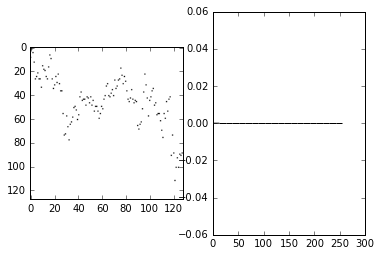

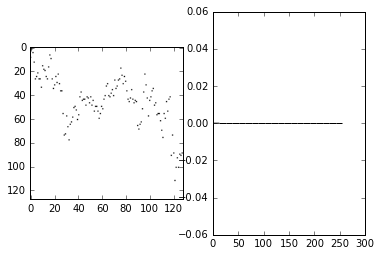

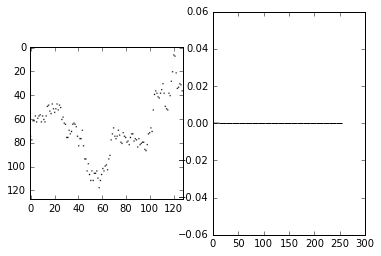

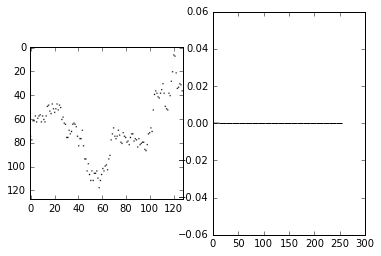

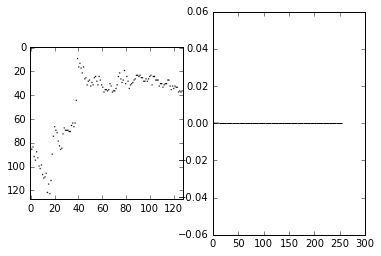

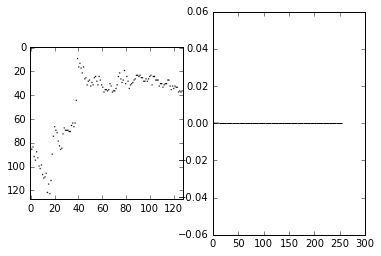

In [7]:
sampleConvertedImages(data[0:maxrows], labels, slidingWindow, dataBasePath,1, 3)

In [8]:
from __future__ import division, print_function, absolute_import
#Hyperparamters
validationPC = 0.1


# Import tflearn and some helpers
import tflearn, numpy as np
from tflearn.data_utils import shuffle, to_categorical
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation
from tflearn.layers.normalization import local_response_normalization

import pickle

# Load path/class_id image file:
dataBasePath = '/home/dev/data/prep-5M-EURUSD-150k/'
dataset_file = dataBasePath + 'labels.txt'

# Build the preloader array, resize images to 128x128
from tflearn.data_utils import image_preloader
#X, Y = image_preloader(dataset_file, image_shape=(128, 128),   mode='file', categorical_labels=True,   normalize=True)
Y = np.load(dataBasePath + 'labelsRaw.npy')
X = np.load(dataBasePath + 'raw.npy')

Y = to_categorical(Y, 2)

# Make sure the data is normalized
img_prep = ImagePreprocessing()

# 1st 50K of dataset Close Only Grey
img_prep.add_featurewise_zero_center(mean=-0.5)
img_prep.add_featurewise_stdnorm(std=0.000345241)

# Calc each time...
#img_prep.add_featurewise_zero_center()
#img_prep.add_featurewise_stdnorm()

# Define our network architecture:

# Input is a 32x32 image with 3 color channels (red, green and blue)
network = input_data(shape=[None, 128, 128, 1],
                     data_preprocessing=img_prep)

# Step 1: Convolution
network = conv_2d(network, 64, 11, strides=2, activation='relu')
network = max_pool_2d(network, 3, strides=2)
network = local_response_normalization(network)
# # Step 4: Convolution yet again
network = conv_2d(network, 256, 9, activation='relu')
network = max_pool_2d(network, 3, strides=2)
network = local_response_normalization(network)

network = conv_2d(network, 592, 3, activation='relu')
network = conv_2d(network, 384, 3, activation='relu')
network = max_pool_2d(network, 2, strides=1)
network = local_response_normalization(network)
# network = local_response_normalization(network)
# network = conv_2d(network, 256, 1, activation='relu')

network = fully_connected(network, 512, activation='relu')
network = dropout(network, 0.8)
network = fully_connected(network, 512, activation='relu')
# network = fully_connected(network, 256, activation='relu')
network = dropout(network, 0.5)

# Step 8: Fully-connected neural network with two outputs (0=isn't a bird, 1=is a bird) to make the final prediction
network = fully_connected(network, 2, activation='softmax', restore=True)

# Tell tflearn how we want to train the network
network = regression(network, optimizer='adam',
                     loss='categorical_crossentropy',
                     learning_rate=0.000001)

# Wrap the network in a model object
model = tflearn.DNN(network, tensorboard_verbose=0, max_checkpoints=15,
                    checkpoint_path='/home/dev/data-science/next-interval-classifier.checkpoints/next-interval-classifier-150k-grey-closeonly.tfl.ckpt')


In [9]:
# Train it! We'll do 100 training passes and monitor it as it goes.
model.fit(X, Y, n_epoch=30, shuffle=False, validation_set=validationPC,
          show_metric=True, batch_size=30,
          snapshot_epoch=True,
          run_id='next-interval-150k-grey-closeonly-04')

# Save model when training is complete to a file
model.save("next-interval-classifier-grey-50k-closeonly.tfl")

Training Step: 134910  | total loss: 0.60301
| Adam | epoch: 030 | loss: 0.60301 - acc: 0.6734 | val_loss: 0.73047 - val_acc: 0.4918 -- iter: 134884/134884
Training Step: 134910  | total loss: 0.60301
| Adam | epoch: 030 | loss: 0.60301 - acc: 0.6734 | val_loss: 0.73047 - val_acc: 0.4918 -- iter: 134884/134884
--


Length 5472
[ 1.11672  1.11723  1.1166   1.11713]
[ 1.11713  1.11743  1.11705  1.11731]
[ 1.11732  1.1175   1.11727  1.1175 ]
[ 1.11749  1.11767  1.11737  1.1175 ]
[ 1.1175   1.11752  1.11727  1.11731]
[ 1.11731  1.11734  1.11692  1.11701]
[ 1.11701  1.11705  1.1167   1.11704]
[ 1.11704  1.11709  1.11684  1.11694]
[ 1.11694  1.1174   1.11694  1.11732]
[ 1.11732  1.11732  1.11697  1.11699]
('Processing imageCount:', '1272')
Processing pass: 0, index: 0
('ImagesArray: Std=0.000343923552203', 'Mean=-0.4999696021')
[1 1 1 0 1 0 0 0 1 0] 1272
1272
['/home/dev/data/prep-5M-EURUSD-Unseen-2016-08-19/0-127.png 1'
 '/home/dev/data/prep-5M-EURUSD-Unseen-2016-08-19/1-128.png 1'
 '/home/dev/data/prep-5M-EURUSD-Unseen-2016-08-19/2-129.png 1'
 '/home/dev/data/prep-5M-EURUSD-Unseen-2016-08-19/3-130.png 0'
 '/home/dev/data/prep-5M-EURUSD-Unseen-2016-08-19/4-131.png 1']
('Good:1272', 'Bad:0')
('Sample Row Close:', '1.11314')
('Next Row Close  :', '1.11318')
('Label:', 1, 'Diff:', '4e-05')
('0) Selected 

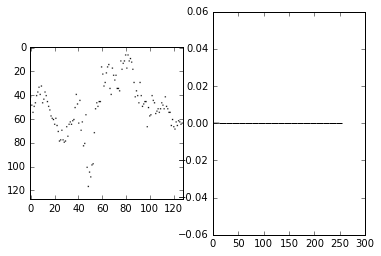

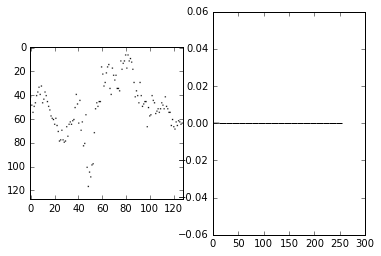

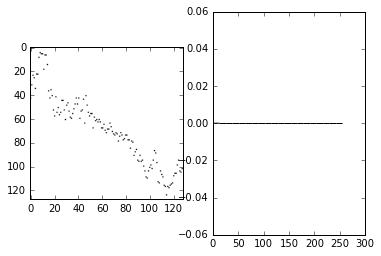

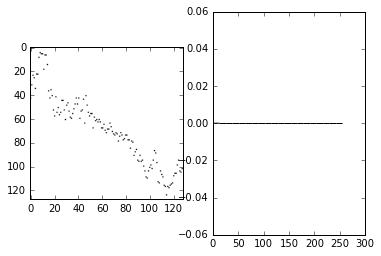

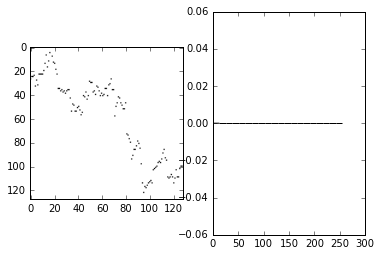

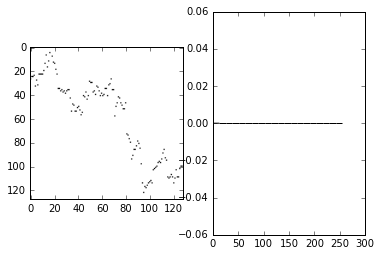

In [5]:
from sklearn.metrics import classification_report
import tflearn, numpy as np
from tflearn.data_utils import shuffle, to_categorical
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.layers.normalization import local_response_normalization

#Set up some variables for the Evaluation of the Models predicitve power...
newDatacsv = '/home/dev/data/EURUSD_Candlestick_5_m_BID_01.08.2016-19.08.2016.csv'
dataUnseenBasePath = '/home/dev/data/prep-5M-EURUSD-Unseen-2016-08-19/'

# Load New Unseen Data from CSV...
data = np.loadtxt(newDatacsv, skiprows=1, usecols=(2, 3, 4, 5), delimiter=',', dtype='f8')
maxrows = 1400#len(data)#

#Check it looks ok...
print ("Length" , len(data))
for row in range(0,10):
 print (data[row])

#generate images from new interval data
generateImagesArray(data[0:maxrows], slidingWindow, dataUnseenBasePath,1)

#generate labels array to sit alongisde the input interval data 
labels = generateAlignedLabels(data[0:maxrows], slidingWindow)
print (labels[0:10], len(labels))
np.save(dataUnseenBasePath + 'labelsRaw.npy', labels)
labelFile = generateLabelFile(labels,slidingWindow, dataUnseenBasePath)
print (labelFile[0:5])
np.savetxt(dataUnseenBasePath + 'labels.txt', labelFile, fmt='%s')

#pick some input/label pairs at random and plot to show we haven't mangled anything...
sampleConvertedImages(data[0:maxrows], labels, slidingWindow, dataUnseenBasePath,1, 3)

Y = np.load(dataUnseenBasePath + 'labelsRaw.npy')
X = np.load(dataUnseenBasePath + 'raw.npy')
Y_eval = to_categorical(Y, 2)

In [6]:
# Validate on unseen data...


# # pass to image preprocessing to get into correct format for network
# img_prep = ImagePreprocessing()
# img_prep.add_featurewise_zero_center()
# img_prep.add_featurewise_stdnorm()

# #redefine network for model we are going to load in...
# network = input_data(shape=[None, 32, 32, 1],
#                      data_preprocessing=img_prep)
# network = conv_2d(network, 16, 3, activation='relu')
# network = conv_2d(network, 256, 5, activation='relu')
# network = max_pool_2d(network, 2)
# network = conv_2d(network, 384, 3, activation='relu')
# network = conv_2d(network, 384, 3, activation='relu')
# network = max_pool_2d(network, 2)
# network = conv_2d(network, 256, 3, activation='relu')

# network = fully_connected(network, 1024, activation='relu')
# network = fully_connected(network, 1024, activation='relu')
# network = fully_connected(network, 2, activation='softmax', restore=True)


# img_prep = ImagePreprocessing()
# img_prep.add_featurewise_zero_center()
# img_prep.add_featurewise_stdnorm()
# Input is a 32x32 image with 3 color channels (red, green and blue)
network = input_data(shape=[None, 128, 128, 1]) #,data_preprocessing=img_prep)

# Step 1: Convolution
network = conv_2d(network, 64, 1, activation='relu')
network = max_pool_2d(network, 2)
network = conv_2d(network, 128, 1, activation='relu')
network = max_pool_2d(network, 2)
network = fully_connected(network, 512, activation='relu')
network = fully_connected(network, 512, activation='relu')
network = fully_connected(network, 2, activation='softmax', restore=True)

model = tflearn.DNN(network)
modelPath = '/home/dev/data-science/next-interval-classifier.checkpoints/'
# Load pre-existing model, restoring all weights
# model.load('/home/dev/data-science/next-interval-classifier.best/next-interval-classifier.ft-full.tfl.ckpt-19978')
# model.load('/home/dev/data-science/next-interval-classifier.best/next-interval-classifier-50k.tfl.ckpt-2475')
model.load(modelPath + 'next-interval-classifier-50k-grey-closeonly.tfl.ckpt-33675', weights_only=True)


NotFoundError: Tensor name "FullyConnected_5/b" not found in checkpoint files /home/dev/data-science/next-interval-classifier.checkpoints/next-interval-classifier-50k-grey-closeonly.tfl.ckpt-33675
	 [[Node: save_6/restore_slice_19 = RestoreSlice[dt=DT_FLOAT, preferred_shard=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_6/Const_0, save_6/restore_slice_19/tensor_name, save_6/restore_slice_19/shape_and_slice)]]
	 [[Node: save_6/restore_slice_9/_39 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_21_save_6/restore_slice_9", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
Caused by op u'save_6/restore_slice_19', defined at:
  File "/usr/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 498, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2705, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2809, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2869, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-5764c28dcb27>", line 40, in <module>
    model = tflearn.DNN(network)
  File "/usr/local/lib/python2.7/dist-packages/tflearn/models/dnn.py", line 63, in __init__
    best_val_accuracy=best_val_accuracy)
  File "/usr/local/lib/python2.7/dist-packages/tflearn/helpers/trainer.py", line 140, in __init__
    keep_checkpoint_every_n_hours=keep_checkpoint_every_n_hours)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/training/saver.py", line 861, in __init__
    restore_sequentially=restore_sequentially)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/training/saver.py", line 519, in build
    filename_tensor, vars_to_save, restore_sequentially, reshape)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/training/saver.py", line 272, in _AddRestoreOps
    values = self.restore_op(filename_tensor, vs, preferred_shard)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/training/saver.py", line 187, in restore_op
    preferred_shard=preferred_shard)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/io_ops.py", line 203, in _restore_slice
    preferred_shard, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_io_ops.py", line 359, in _restore_slice
    preferred_shard=preferred_shard, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 703, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2310, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1232, in __init__
    self._traceback = _extract_stack()


In [9]:
print np.shape(X), np.shape(Y)
batchSize = 10
# Need to cycle round predicting each batch and appending it to an array for F1 scoring


# Feed new, unseen data to model and see how it performs...
predictOutput = np.array(model.predict(X))
#evaluateOutput = model.evaluate(X,Y_eval)
del model

print predictOutput
y_pred = np.around(predictOutput[:,0])
print y_pred
print(classification_report(Y, y_pred))

#print evaluateOutput
#>>> y_true = [0, 1, 2, 2, 2]
#>>> y_pred = [0, 0, 2, 2, 1]
#>>> target_names = ['class 0', 'class 1', 'class 2']
#>>> print(classification_report(y_true, y_pred, target_names=target_names))

(1272, 128, 128, 1) (1272,)


ResourceExhaustedError: OOM when allocating tensor with shape[1272,128,128,64]
	 [[Node: Conv2D/BiasAdd = BiasAdd[T=DT_FLOAT, data_format="NHWC", _device="/job:localhost/replica:0/task:0/gpu:0"](Conv2D/Conv2D, Conv2D/b/read)]]
Caused by op u'Conv2D/BiasAdd', defined at:
  File "/usr/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 498, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2705, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2809, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2869, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-3bbed5ab155e>", line 33, in <module>
    network = conv_2d(network, 64, 1, activation='relu')
  File "/usr/local/lib/python2.7/dist-packages/tflearn/layers/conv.py", line 98, in conv_2d
    if b: inference = tf.nn.bias_add(inference, b)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/nn_ops.py", line 391, in bias_add
    return gen_nn_ops._bias_add(value, bias, data_format=data_format, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_nn_ops.py", line 279, in _bias_add
    data_format=data_format, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 703, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2310, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1232, in __init__
    self._traceback = _extract_stack()
